In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import pandas_ta as ta
from pandas_ta import bbands
from scipy.ndimage import label

In [2]:
# Fetching gold data from the API for the past 10 yrs
def fetching_gold_data():
    df = yf.download('GC=F',period='10y',interval='1d')

    # Cleaning the columns as yfinance returns Multi-index columns sometime
    if isinstance(df.columns,pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df

In [3]:
df = fetching_gold_data()
df.tail()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2026-01-14,4626.299805,4635.000000,4608.200195,4610.299805,1313
2026-01-15,4616.299805,4616.299805,4612.899902,4612.899902,4358
2026-01-16,4588.399902,4608.000000,4588.399902,4608.000000,352
2026-01-20,4759.600098,4764.000000,4661.799805,4662.200195,352
2026-01-21,4838.700195,4891.100098,4761.500000,4767.500000,274468


In [4]:
df.describe()

Price,Close,High,Low,Open,Volume
count,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000
mean,1850.550118,1859.509030,1840.956285,1849.829276,5290.858791
std,693.847886,698.592131,687.809128,692.413218,29040.225736
min,1097.199951,1103.199951,1094.099976,1098.000000,0.000000
25%,1303.300049,1307.199982,1297.325043,1302.075012,53.000000
50%,1762.850037,1772.150024,1756.750000,1763.850037,214.000000
75%,1965.875000,1973.950012,1956.649963,1965.875031,656.000000
max,4838.700195,4891.100098,4761.500000,4767.500000,386334.000000


In [5]:
df.isnull().sum()

Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

## Feature Engineering

In [6]:
# Applying the features in the dataset
def apply_features(df):
    # Calculating  the SMA feature
    df["SMA_20"] = ta.sma(df['Close'], 20)

    # Calculating EMA feature
    df["EMA_20"] = ta.ema(df['Close'], 20)

    # Calculating the RSI
    df['RSI_14'] = ta.rsi(df['Close'], 14)

    # calculating the Bbands
    bb_cols = ("BBL_20", "BBM_20", "BBU_20", "BBB_20", "BBP_20")
    # unpack the result into  dataframe
    df[list(bb_cols)] = ta.bbands(df['Close'], length=20, std=2.0)

    df['ATR_14'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)

    # Creating the Target column
    df["Target"] = df['Close'].shift(-1)

    # Drop rows where indicators couldn't be calculated (first 20 rows)
    # and the last row (where target is NaN)
    return df.dropna()


In [7]:
df_features = apply_features(df)
print(np.isnan(df_features).any())

df_features.head()

Price
Close     False
High      False
Low       False
Open      False
Volume    False
SMA_20    False
EMA_20    False
RSI_14    False
BBL_20    False
BBM_20    False
BBU_20    False
BBB_20    False
BBP_20    False
ATR_14    False
Target    False
dtype: bool


Price,Close,High,Low,Open,Volume,SMA_20,EMA_20,RSI_14,BBL_20,BBM_20,BBU_20,BBB_20,BBP_20,ATR_14,Target
Date,,,,,,,,,,,,,,,
2016-02-18,1226.099976,1239.199951,1201.599976,1209.599976,315,1160.379993,1160.379993,70.393453,1060.204507,1160.379993,1260.555478,17.265979,0.828024,21.769678,1230.400024
2016-02-19,1230.400024,1232.800049,1221.800049,1230.800049,76,1166.944995,1167.048567,71.250299,1066.469875,1166.944995,1267.420116,17.220198,0.815775,21.000415,1209.500000
2016-02-22,1209.500000,1226.099976,1203.000000,1226.099976,280,1172.559998,1171.091561,61.876817,1076.021564,1172.559998,1269.098432,16.466268,0.691323,21.457530,1222.300049
2016-02-23,1222.300049,1226.099976,1207.400024,1207.400024,351,1178.365002,1175.968560,64.920614,1084.708425,1178.365002,1272.021580,15.896022,0.734554,21.260560,1238.699951
2016-02-24,1238.699951,1250.099976,1230.000000,1230.000000,111,1184.215002,1181.942978,68.401627,1090.845547,1184.215002,1277.584458,15.769004,0.791771,21.727658,1238.199951


In [8]:
# Dropping the non required columns from the dataset
required_cols = ['Close', 'SMA_20', 'EMA_20', 'RSI_14',
        'BBL_20', 'BBU_20', 'ATR_14', 'Target']
# Drop everything else (Open, High, Low, Volume, Adj Close)
df_final = df_features[required_cols].copy()
print(f"Shape of final dataset: {df_final.shape}")

Shape of final dataset: (2494, 8)


## Graphs and correlation

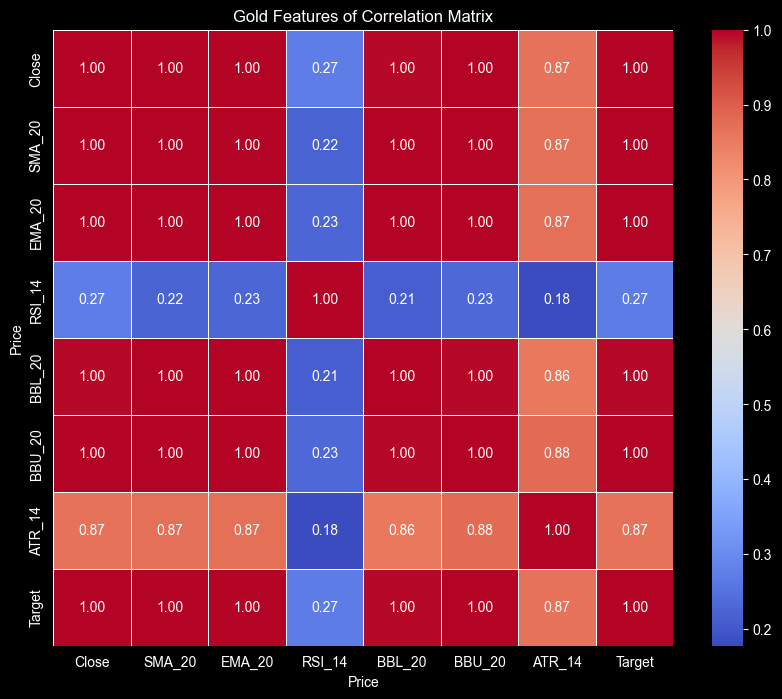

In [9]:
# Plotting the correlation metrics
corr_matrix = df_final.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",fmt=".2f",linewidths=0.5)
plt.title("Gold Features of Correlation Matrix")
plt.show()

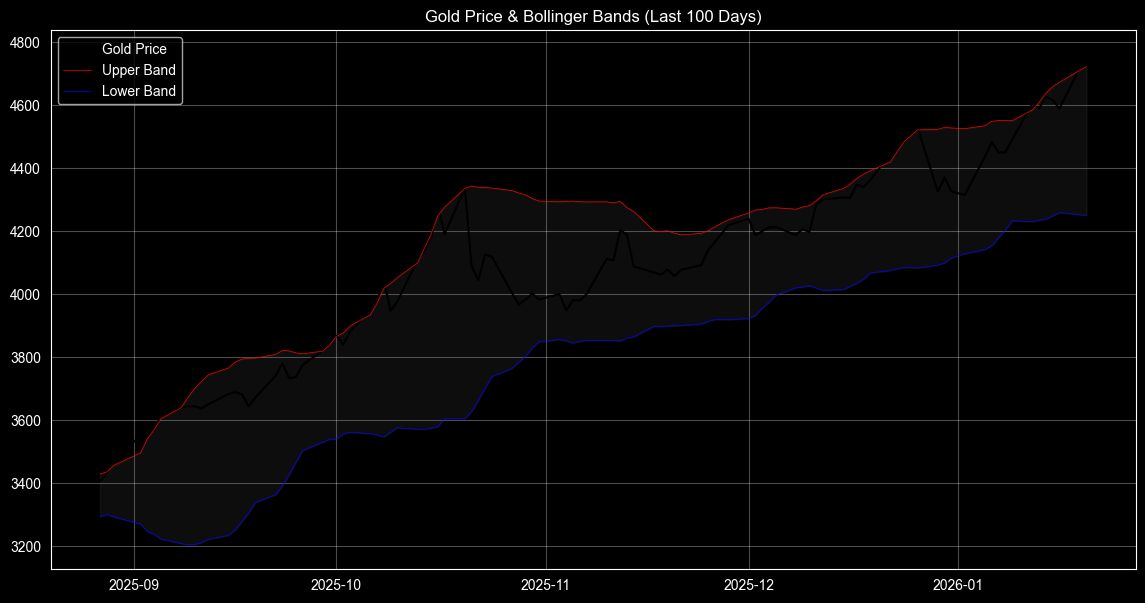

In [10]:
# Plotting technical features
def plot_tech_fet(df_final,days=100):
    #plotting 100 days to keep the graph readable
    recent_df = df_final.tail(days)
    plt.figure(figsize=(14,7))

    # plot Price and Bands
    plt.plot(recent_df.index,recent_df['Close'],label='Gold Price',color='Black',linewidth=1.5)
    plt.plot(recent_df.index,recent_df['BBU_20'],label='Upper Band',color='red',linewidth=0.5)
    plt.plot(recent_df.index,recent_df['BBL_20'],label='Lower Band',color='blue',linewidth=0.5)

    # Fill the area between bands
    plt.fill_between(recent_df.index,recent_df['BBL_20'],recent_df['BBU_20'],color='gray',alpha=0.1)
    plt.title(f"Gold Price & Bollinger Bands (Last {days} Days)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_tech_fet(df_final)

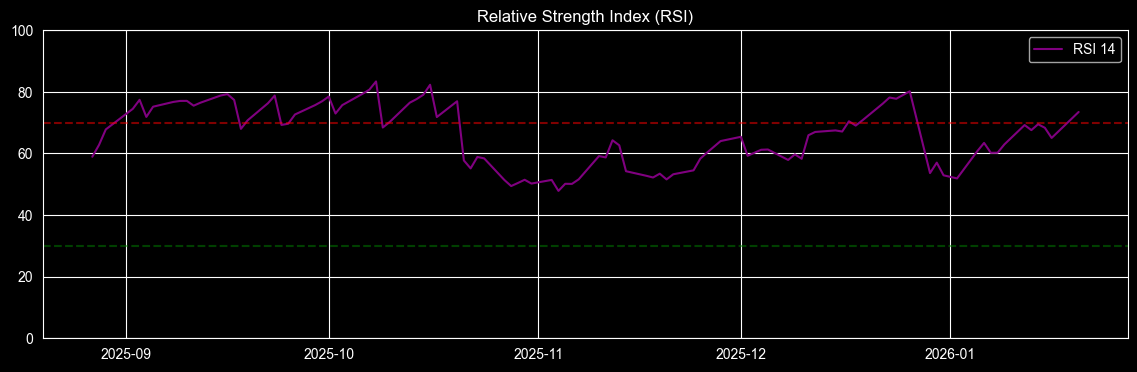

In [11]:
def plot_rsi(df_final, days=100):
    recent_df = df_final.tail(days)

    plt.figure(figsize=(14, 4))
    plt.plot(recent_df.index, recent_df['RSI_14'], label='RSI 14', color='purple')

    # Add horizontal signal lines
    plt.axhline(70, color='red', linestyle='--', alpha=0.5)
    plt.axhline(30, color='green', linestyle='--', alpha=0.5)

    plt.title("Relative Strength Index (RSI)")
    plt.ylim(0, 100)
    plt.legend()
    plt.show()

plot_rsi(df_final)

## Splitting the dataset and Standard Scaler

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
import joblib

In [14]:
def split_and_scale(df_final,train_ratio=0.8):
    split_idx = int(len(df_final)*train_ratio)
    # Features to apply scaling (don't include target)
    feature_cols = ['Close', 'SMA_20', 'EMA_20', 'RSI_14', 'BBL_20', 'BBU_20', 'ATR_14']

    train_df = df_final.iloc[:split_idx]
    test_df = df_final.iloc[split_idx:]

    # Scaling the dataset
    scaler_X = MinMaxScaler(feature_range=(0,1))
    scaler_Y = MinMaxScaler(feature_range=(0,1))


    # Transform the data
    X_train_scaled = scaler_X.fit_transform(train_df[feature_cols])
    X_test_scaled = scaler_X.transform(test_df[feature_cols])

    y_train_scaled = scaler_Y.fit_transform(train_df[['Target']])
    y_test_scaled = scaler_Y.transform(test_df[['Target']])

    # Save the scaler for later
    joblib.dump(scaler_X,'gold_scaler_X.pkl')
    joblib.dump(scaler_Y, 'gold_scaler_Y.pkl')


    return X_train_scaled, X_test_scaled, y_train_scaled.flatten(), y_test_scaled.flatten()

# Split into Train (8 years) and Test (2 years)
X_train_raw, X_test_raw, y_train_val, y_test_val = split_and_scale(df_final)

In [15]:
print("Checking for NaNs in X_train:", np.isnan(X_train_raw).any())
print("Checking for NaNs in y_train:", np.isnan(y_train_val).any())
print("Checking for Infinity in X_train:", np.isinf(X_train_raw).any())

# If any are True, you must find where your dropna() failed.

Checking for NaNs in X_train: False
Checking for NaNs in y_train: False
Checking for Infinity in X_train: False


In [16]:
nan_in_x = np.isnan(X_train_raw).sum()
print(nan_in_x)

0


## Creating the window dataset

In [17]:
def dataset_window(data_scaled,target_values,window_size=29):
    X,y = [],[]
    for i in range(window_size,len(data_scaled)):
        X.append(data_scaled[i-window_size:i])
        y.append(target_values[i])
    return np.array(X),np.array(y)

X_train, y_train = dataset_window(X_train_raw, y_train_val)
X_test, y_test = dataset_window(X_test_raw, y_test_val)

print(f"Total Samples: {len(df_final)}")
print(f"Training Windows: {X_train.shape}") # (Samples, 30 days, 7 features)
print(f"Testing Windows: {X_test.shape}")

Total Samples: 2494
Training Windows: (1966, 29, 7)
Testing Windows: (470, 29, 7)


In [18]:
print(np.isnan(X_train).any())
print(np.isnan(X_test).any())

False
False


## Building the LSTM Architecture

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [20]:
from tensorflow.keras.optimizers import Adam


In [24]:
# Architecture
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Change 0.001 to 0.0001
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mae',metrics=['mae'])

# Early stopping, callbacks and Model Checkpoint
# Save the best version of the model based on validation loss
# checkpoint = ModelCheckpoint(
#     'best_gold_model.keras',
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )

# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [25]:
# 3. TRAINING
print("Starting training...")
history = model.fit(
        X_train, y_train,
        epochs=80,
        batch_size=32,
        validation_data=(X_test, y_test),

        verbose=1
    )
# Saving the final model explicitly
model.save('final_gold_model.keras')

Starting training...
Epoch 1/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.3144 - mae: 0.3144 - val_loss: 1.1314 - val_mae: 1.1314
Epoch 2/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0708 - mae: 0.0708 - val_loss: 1.0000 - val_mae: 1.0000
Epoch 3/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0628 - mae: 0.0628 - val_loss: 0.9563 - val_mae: 0.9563
Epoch 4/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0572 - mae: 0.0572 - val_loss: 0.8689 - val_mae: 0.8689
Epoch 5/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0520 - mae: 0.0520 - val_loss: 0.8888 - val_mae: 0.8888
Epoch 6/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0528 - mae: 0.0528 - val_loss: 0.8782 - val_mae: 0.8782
Epoch 7/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0501 - mae: 0.0501 - val_loss: 0.8345 - val_mae: 0.8345
Epoch 8/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0482 - mae: 0.0482 - val_loss: 0.8324 - val_mae: 0.8324
Epoch 9/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19

## Predictions for Y test

In [26]:
def evaluate_and_predict(model,X_test,y_test,scaler_Y = 'gold_scaler_Y.pkl'):
    scaler_Y = joblib.load(scaler_Y)
    # Predicting the data points
    y_pred_scaled = model.predict(X_test)

    # Inverse transform to get actual USD prices
    # We must reshape to 2D for the scaler, then flatten back
    y_pred_usd = scaler_Y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
    y_test_usd = scaler_Y.inverse_transform(y_test.reshape(-1,1)).flatten()

    return y_pred_usd, y_test_usd

y_pred_usd,y_test_usd = evaluate_and_predict(model,X_test,y_test,scaler_Y='gold_scaler_Y.pkl')

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


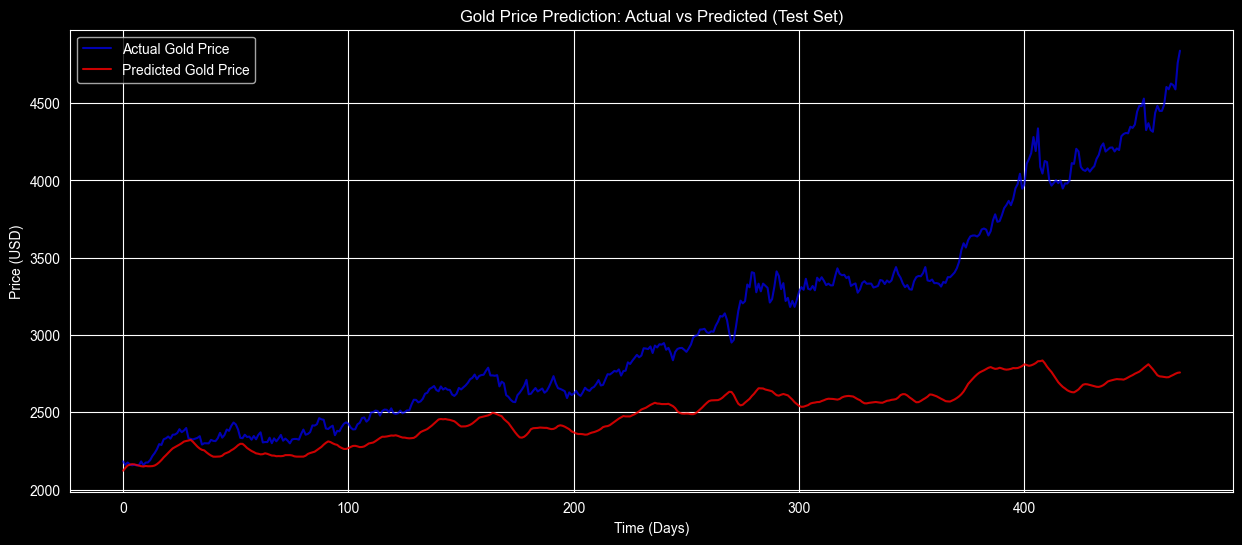

In [29]:
# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(y_test_usd, label='Actual Gold Price', color='blue', alpha=0.7)
plt.plot(y_pred_usd, label='Predicted Gold Price', color='red', alpha=0.8)
plt.title('Gold Price Prediction: Actual vs Predicted (Test Set)')
plt.xlabel('Time (Days)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()